<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
!pip install -U scikit-learn

In [2]:
!pip install -U imbalanced-learn

In [4]:
#импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE #вот тут закомментировано было - теперь все ок
from imblearn.under_sampling import TomekLinks

In [5]:
#создадим датафрейм с данными из исходного csv файла

data = pd.read_csv('/datasets/Churn.csv')

#просмотрим структуру датафрейма

display(data.head())

print(data.info())

display(data.describe())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Исходный датафрейм включает в себя информацию об оборотах банка. Датафрейм содержит следующие данные:

        Признаки:

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата


        Целевой признак:


Exited — факт ухода клиента



На основании этих данных необходимо спрогнозировать отток клиентов банка.

Всего в датафрейме 10000 строк, однако поле Tenure содержит пустые значения, что вероятно приводит к типу данных float, хотя очевидно что количество человек может быть строго целочисленным. 

In [6]:
#исследуем поле tenure

display(data[data['Tenure'].isna()])

#909 элементов из 10000 являются пустыми - величина существенная. Преобразуем строки с пустыми значениями Tenure. 

data['Tenure'] = data['Tenure'].fillna(0)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Далее просмотрим зависимость параметров. Для этого выделим категориальные и количественные признаки:

RowNumber — порядковый

CustomerId — категориальный

Surname — категориальные

CreditScore — количественные

Geography — категориальные

Gender — категориальные

Age — количественные

Tenure — количественные

Balance — количественные

NumOfProducts — количественные

HasCrCard — категориальные

IsActiveMember — категориальные

EstimatedSalary — количественные

Целевой признак - категориальный


In [7]:
#оценим связь количественных признаков

series = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

data[series].corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
CreditScore,1.000000,-0.003965,0.003087,0.006268,0.012238,-0.001384
Age,-0.003965,1.000000,-0.007368,0.028308,-0.030680,-0.007201
Tenure,0.003087,-0.007368,1.000000,-0.005821,0.010106,0.011225
Balance,0.006268,0.028308,-0.005821,1.000000,-0.304180,0.012797
NumOfProducts,0.012238,-0.030680,0.010106,-0.304180,1.000000,0.014204
EstimatedSalary,-0.001384,-0.007201,0.011225,0.012797,0.014204,1.000000


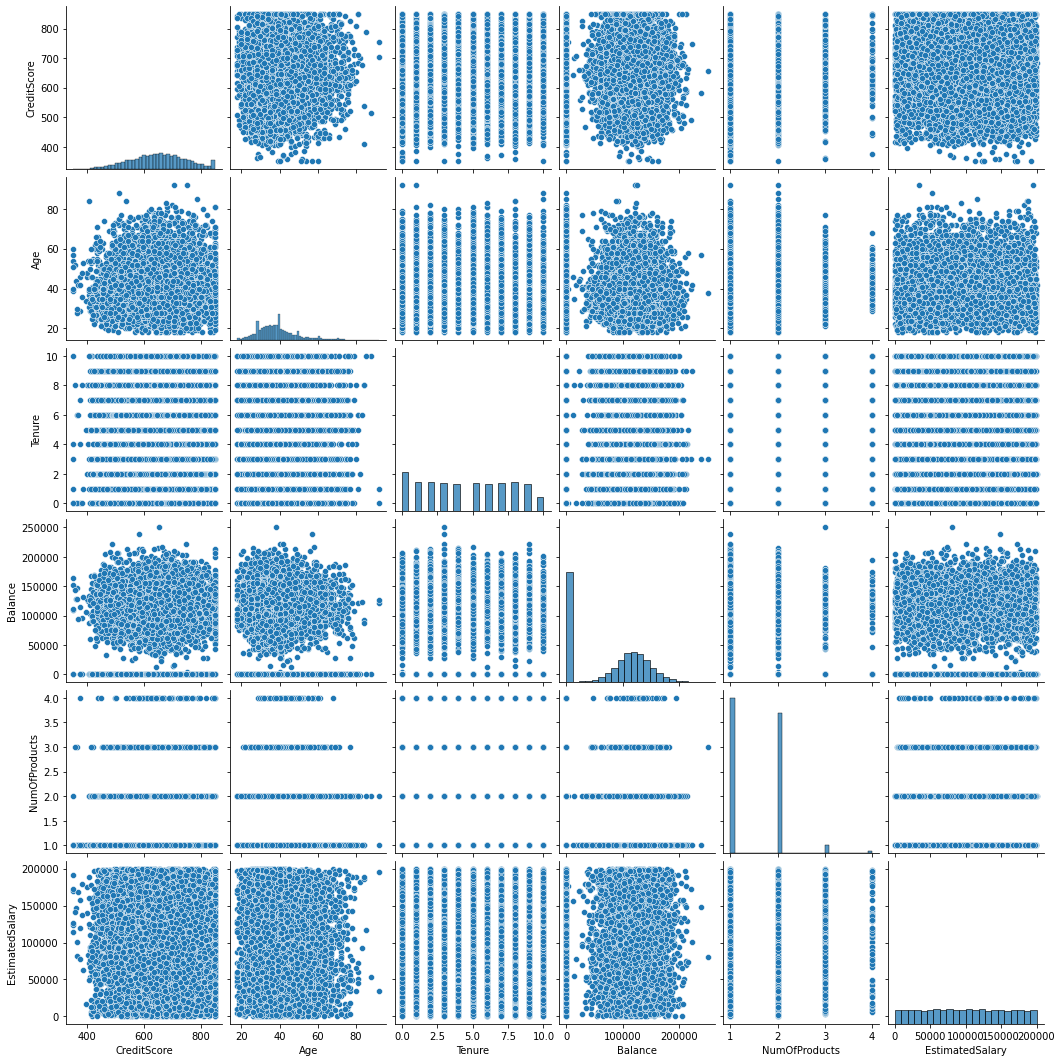

In [8]:
sns.pairplot(data[series])

По итогу анализа мультиколлинеарности в количественных признаках не выявлено, однако очевидно что для дальнейшей работы можно убрать поля Фамилии, порядковый признак и уникальный идентификатор.

In [9]:
data_prev = data
data = data.drop(['RowNumber','CustomerId','Surname'], axis = 1)

Для дальнейшем работы - выделим фичи и целевой признак. Поделим исходный датафрейм на обучающую и тестовую выборки, после чего выделим валидационную выборки - соотношение 60/20/20

In [11]:
X = data.drop('Exited', axis = 1)
Y = data['Exited']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                                X,Y, 
                                                                train_size=0.60, 
                                                                random_state = 12345)
X_test, X_valid = train_test_split(
                                                X_test, 
                                                test_size=0.50, 
                                                random_state = 12345)

Y_test, Y_valid = train_test_split(
                                                Y_test, 
                                                test_size=0.50, 
                                                random_state = 12345)


In [12]:
print('Количество объектов внутри тестовой выборки',X_test['Age'].count())
print('Количество объектов внутри обучающей выборки',X_train['Age'].count())
print('Количество объектов внутри валидационной выборки',X_valid['Age'].count())

print('Величина тестовой выборки',X_test['Age'].count()/data['Age'].count())
print('Величина обучающей выборки',X_train['Age'].count()/data['Age'].count())
print('Величина валидационной выборки',X_valid['Age'].count()/data['Age'].count())

Количество объектов внутри тестовой выборки 2000
Количество объектов внутри обучающей выборки 6000
Количество объектов внутри валидационной выборки 2000
Величина тестовой выборки 0.2
Величина обучающей выборки 0.6
Величина валидационной выборки 0.2


В исходном датафрейме есть часть категориальных признаков, которые необходимо закодировать  - для задачи классификации модель не сможет использовать категориальные признаки - Geography, Gender.

Прочие категориальные признаки могут быть использованы в моделях.

Воспользуемся методом One-Hot Encoding.

Разбросы и значения EstimatedSalary больше чем Age. Чтобы все признаки были равнозначными - следующим этапом масштабируем количественные признаки в обучающей и валидаицонной выборках.

In [14]:
#масштабирование признаков


cat = list(X_train.select_dtypes('object').columns) #категориальные признаки
num = list(X_train.select_dtypes(exclude='object').columns) #количественные признаки


scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[num]), columns=[num], index=X_train.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid[num]), columns=[num], index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num]), columns=[num], index=X_test.index)

In [15]:
#кодирование OHE


enc = OneHotEncoder(handle_unknown='error', drop='first')

X_train_ohe = enc.fit_transform(X_train[cat]) 
X_valid_ohe = enc.transform(X_valid[cat]) 
X_test_ohe = enc.transform(X_test[cat]) 


In [16]:
#формирование единых выборок 

X_train = pd.concat(
                    [X_train_scaled, 
                    pd.DataFrame(X_train_ohe.toarray(), index=X_train.index)], axis=1
                        )

X_valid = pd.concat(
                    [X_valid_scaled, 
                    pd.DataFrame(X_valid_ohe.toarray(), index=X_valid.index)], axis=1
                        )


X_test = pd.concat(
                    [X_test_scaled, 
                    pd.DataFrame(X_test_ohe.toarray(), index=X_test.index)], axis=1
                        )


display(X_train.head(3))

display(X_valid.head(3))

display(X_test.head(3))

,"(CreditScore,)","(Age,)","(Tenure,)","(Balance,)","(NumOfProducts,)","(HasCrCard,)","(IsActiveMember,)","(EstimatedSalary,)",0,1,2
7479,-0.886751,-0.373192,1.104696,1.232271,-0.891560,0.642466,-1.055187,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,1.104696,0.600563,-0.891560,-1.556504,-1.055187,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.503694,1.027098,0.830152,-1.556504,0.947699,1.503095,1.0,0.0,1.0


,"(CreditScore,)","(Age,)","(Tenure,)","(Balance,)","(NumOfProducts,)","(HasCrCard,)","(IsActiveMember,)","(EstimatedSalary,)",0,1,2
7041,-2.226392,-0.088482,-0.825373,-1.233163,0.830152,0.642466,-1.055187,0.647083,0.0,0.0,1.0
5709,-0.087120,0.006422,1.426375,-1.233163,-0.891560,0.642466,-1.055187,-1.658410,0.0,0.0,0.0
7117,-0.917905,-0.752805,0.139662,0.722307,-0.891560,0.642466,0.947699,-1.369334,0.0,1.0,1.0


,"(CreditScore,)","(Age,)","(Tenure,)","(Balance,)","(NumOfProducts,)","(HasCrCard,)","(IsActiveMember,)","(EstimatedSalary,)",0,1,2
8532,-0.699824,-0.373192,-0.825373,-1.233163,0.830152,0.642466,-1.055187,-0.015173,0.0,0.0,0.0
5799,-0.284431,0.575842,-0.503694,-1.233163,-0.891560,0.642466,0.947699,1.471724,0.0,0.0,0.0
5511,0.151731,-0.657902,-1.468729,0.438711,-0.891560,0.642466,-1.055187,-1.367107,1.0,0.0,1.0


Исходные данные не содержат незакодированных категориальных признаков.

Завершив анализ датафрейма, немного скорректировав его и закодировав ряд признаков возможно приступать к дальнейшей работе с данными.

## Исследование задачи

Цель - построить прогнозную модель оттока клиентов банка. Для каждой модели подберем наилучшие параметры сравнивая метрику f1.

In [17]:
tree = DecisionTreeClassifier(random_state=12345)

parametrs = { 'max_depth': range (2,16, 2)}
grid = GridSearchCV(tree, parametrs, scoring = 'f1')
grid.fit(X_train, Y_train)

grid.best_params_

{'max_depth': 10}

In [18]:
model_tree = DecisionTreeClassifier(random_state=12345,max_depth = 10 )
model_tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=10, random_state=12345)

In [19]:
best_model=None
best_result=0
best_est=0
for n in range(10,500,10):
    model=LogisticRegression(random_state=12345,solver='liblinear',max_iter=n)
    model.fit(X_train,Y_train)
    predictions=model.predict(X_valid)
    result=f1_score(Y_valid,predictions)
    if result>best_result:
        best_model=model
        best_result=result
        best_est=n
        
print("F1 лучшей модели:", best_result, 'при количестве', best_est)   

F1 лучшей модели: 0.27478260869565213 при количестве 10


In [20]:
model_log = LogisticRegression(random_state=12345,solver='liblinear',max_iter=10)
model_log.fit(X_train, Y_train)

LogisticRegression(max_iter=10, random_state=12345, solver='liblinear')

In [21]:
forest = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (2,10, 2) }
grid = GridSearchCV(forest, parametrs, scoring = 'f1')
grid.fit(X_train, Y_train)

grid.best_params_

{'max_depth': 8, 'n_estimators': 30}

In [22]:
model_forest = RandomForestClassifier(random_state=12345,n_estimators = 20,max_depth = 8)
model_forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=8, n_estimators=20, random_state=12345)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

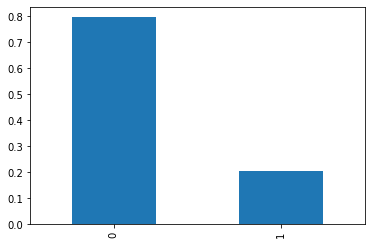

In [23]:
#оценим частоту каждого класса целевого признака.

class_frequency = data['Exited'].value_counts(normalize=True)

print(class_frequency)

class_frequency.plot(kind='bar')

In [24]:
predicted_valid = model_tree.predict(X_valid)

print('Оценка параметров дерева решений')
print(recall_score(Y_valid,predicted_valid))
print(precision_score(Y_valid,predicted_valid))
print(f1_score(Y_valid,predicted_valid))



predicted_valid = model_log.predict(X_valid)

print('Оценка параметров логистической регрессии')
print(recall_score(Y_valid,predicted_valid))
print(precision_score(Y_valid,predicted_valid))
print(f1_score(Y_valid,predicted_valid))




predicted_valid = model_forest.predict(X_valid)

print('Оценка параметров случайного леса')
print(recall_score(Y_valid,predicted_valid))
print(precision_score(Y_valid,predicted_valid))
print(f1_score(Y_valid,predicted_valid))

Оценка параметров дерева решений
0.41843971631205673
0.6483516483516484
0.5086206896551724
Оценка параметров логистической регрессии
0.1867612293144208
0.5197368421052632
0.27478260869565213
Оценка параметров случайного леса
0.3617021276595745
0.765
0.49117174959871585


Частота класса 0 = 80%, класса 1 = 20%.

Наилучшая метрика f1 у дерева решений, при этом f1 ниже 59%.

Приступим к исправлению дисбаланса.

## Борьба с дисбалансом

Для решения проблемы с дисбалансом классов есть несколько методов. Воспользуемся каждым и определим F1 меру.

In [25]:
#воспользуемся взвешиванием классов и подберем наилучшие параметры.

tree = DecisionTreeClassifier(random_state=12345,class_weight='balanced')

parametrs = { 'max_depth': range (2,16, 2)}
grid = GridSearchCV(tree, parametrs, scoring = 'f1')
grid.fit(X_train, Y_train)

grid.best_params_

{'max_depth': 6}

In [26]:
forest = RandomForestClassifier(random_state=12345,class_weight='balanced')

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (2,10, 2) }
grid = GridSearchCV(forest, parametrs, scoring = 'f1')
grid.fit(X_train, Y_train)

grid.best_params_

{'max_depth': 8, 'n_estimators': 20}

In [27]:
logist_model = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')


parametrs = { 'max_iter': range (10, 1000, 10)}
grid = GridSearchCV(logist_model, parametrs, scoring = 'f1')
grid.fit(X_train, Y_train)

grid.best_params_


{'max_iter': 10}

In [28]:
#оценим f1 меру

model_tree = DecisionTreeClassifier(random_state=12345, max_depth = 6, class_weight='balanced')
model_log = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced', max_iter = 10)
model_forest = RandomForestClassifier(random_state=12345,class_weight='balanced', max_depth= 8, n_estimators= 20)

model_tree.fit(X_train, Y_train)
model_log.fit(X_train, Y_train)
model_forest.fit(X_train, Y_train)


predicted_valid = model_tree.predict(X_valid)
probabilities_valid = model_tree.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров дерева решений')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))


predicted_valid = model_log.predict(X_valid)
probabilities_valid = model_log.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров логистической регрессии')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))



predicted_valid = model_forest.predict(X_valid)
probabilities_valid = model_forest.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров случайного леса')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))

Оценка параметров дерева решений
0.5643835616438356
0.8194375111494879
Оценка параметров логистической регрессии
0.4797238999137188
0.7417276421850147
Оценка параметров случайного леса
0.6052631578947368
0.848522870878812


Метод взвешивания классов дает наилучшую F1 меру 60,5% по случайному лесу - по данной модели также наилучший auc_roc.

Приступим к методу увеличения выборки.

In [30]:
sm = SMOTE(random_state=12345, sampling_strategy = 'minority')

In [31]:
X_upsampled, Y_upsampled = sm.fit_resample(X_train, Y_train)

In [32]:
tree = DecisionTreeClassifier(random_state=12345)

parametrs = { 'max_depth': range (2,16, 2)}
grid = GridSearchCV(tree, parametrs, scoring = 'f1')
grid.fit(X_upsampled, Y_upsampled)

grid.best_params_

{'max_depth': 14}

In [33]:
forest = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (2,10, 2) }
grid = GridSearchCV(forest, parametrs, scoring = 'f1')
grid.fit(X_upsampled, Y_upsampled)

grid.best_params_

{'max_depth': 8, 'n_estimators': 30}

In [34]:
logist_model = LogisticRegression(random_state=12345,solver='liblinear')


parametrs = { 'max_iter': range (10, 1000, 10)}
grid = GridSearchCV(logist_model, parametrs, scoring = 'f1')
grid.fit(X_upsampled, Y_upsampled)

grid.best_params_

{'max_iter': 10}

In [35]:
#оценим f1 меру

model_tree = DecisionTreeClassifier(random_state=12345, max_depth = 15)
model_log = LogisticRegression(random_state=12345,solver='liblinear', max_iter = 10)
model_forest = RandomForestClassifier(random_state=12345, max_depth= 8, n_estimators= 30)

model_tree.fit(X_train, Y_train)
model_log.fit(X_train, Y_train)
model_forest.fit(X_train, Y_train)


predicted_valid = model_tree.predict(X_valid)
probabilities_valid = model_tree.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров дерева решений')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))


predicted_valid = model_log.predict(X_valid)
probabilities_valid = model_log.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров логистической регрессии')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))



predicted_valid = model_forest.predict(X_valid)
probabilities_valid = model_forest.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров случайного леса')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))

Оценка параметров дерева решений
0.4830188679245283
0.6830659704888986
Оценка параметров логистической регрессии
0.27478260869565213
0.7386664987684968
Оценка параметров случайного леса
0.49025974025974023
0.8485850831470713


Метод увеличения выборки дает F1 меру меньше 50% по всем использованным моделям. Метрика auc_roc больше всего отличается от метрики случайной модели - в модели случайного леса, в этой же модели наилучшая f1 мера при оверсэмплинге.

Далее попробуем метод уменьшения выборки

In [37]:
tl = TomekLinks(sampling_strategy='majority')

In [38]:
X_downsampled, Y_downsampled = tl.fit_resample(X_train, Y_train)

In [39]:
tree = DecisionTreeClassifier(random_state=12345)

parametrs = { 'max_depth': range (2,16, 2)}
grid = GridSearchCV(tree, parametrs, scoring = 'f1')
grid.fit(X_downsampled, Y_downsampled)

grid.best_params_

{'max_depth': 8}

In [40]:
forest = RandomForestClassifier(random_state=12345)

parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (2,10, 2) }
grid = GridSearchCV(forest, parametrs, scoring = 'f1')
grid.fit(X_downsampled, Y_downsampled)

grid.best_params_

{'max_depth': 8, 'n_estimators': 40}

In [41]:
logist_model = LogisticRegression(random_state=12345,solver='liblinear')


parametrs = { 'max_iter': range (10, 1000, 10)}
grid = GridSearchCV(logist_model, parametrs, scoring = 'f1')
grid.fit(X_downsampled, Y_downsampled)

grid.best_params_

{'max_iter': 10}

In [42]:
#оценим f1 меру

model_tree = DecisionTreeClassifier(random_state=12345, max_depth = 8)
model_log = LogisticRegression(random_state=12345,solver='liblinear', max_iter = 10)
model_forest = RandomForestClassifier(random_state=12345, max_depth= 8, n_estimators= 40)

model_tree.fit(X_train, Y_train)
model_log.fit(X_train, Y_train)
model_forest.fit(X_train, Y_train)


predicted_valid = model_tree.predict(X_valid)
probabilities_valid = model_tree.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров дерева решений')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))


predicted_valid = model_log.predict(X_valid)
probabilities_valid = model_log.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров логистической регрессии')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))



predicted_valid = model_forest.predict(X_valid)
probabilities_valid = model_forest.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('Оценка параметров случайного леса')
print(f1_score(Y_valid,predicted_valid))
print(roc_auc_score(Y_valid,probabilities_one_valid))

Оценка параметров дерева решений
0.4992343032159265
0.8044436049535956
Оценка параметров логистической регрессии
0.27478260869565213
0.7386664987684968
Оценка параметров случайного леса
0.4761904761904762
0.8530201432830987


Андерсэмплинг выборки все также дает F1 меру меньше 50% по всем использованным моделям. Метрика auc_roc больше всего отличается от метрики случайной модели - в модели случайного леса, в этой же модели наилучшая f1 мера при андерсэмплинге.

In [43]:
model_forest = RandomForestClassifier(random_state=12345,class_weight='balanced', max_depth= 8, n_estimators= 20)
model_forest.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=20,
                       random_state=12345)

Таким образом, наилучшая модель - случайный лес при методе - взвешивание классов. F1 мера - 60,5%, auc-roc = 84%.

## Тестирование модели

In [44]:
predictions_test=model_forest.predict(X_test)
result=f1_score(Y_test,predictions_test)
auc_roc = roc_auc_score(Y_test,predictions_test)
probabilities_valid = model_forest.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]


print('F1 на тестовой выборке:',result)

print('Auc-Roc на тестовой выборке:',auc_roc)

F1 на тестовой выборке: 0.6143790849673202
Auc-Roc на тестовой выборке: 0.7684204477404292


Таким образом, наилучшая модель по F1 мере по тестовой выборке - случайный лес при взвешивании классов. Но при этом auc-roc наибольший в модели случайного леса при андерсэмплинге с помощью TomekLinks.

Итоговый вывод:
    
    1. данные были обработаны на пустые значения, были закодированы категориальные признаки и масштабированы количественные признаки
    2. первоначальные модели были оценены на адекватность с учетом подобранных параметров
    3. при выявлении несбалансированности классов были использованы три метода: взвешивание, уменьшение и увеличение выборок
    4. итоговые модели были протестированы на тестовой выборке и выбраны наилучшая по F1 мере и auc_roc - случайный лес при получении сбалансированности классов при помощи взвешивания.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*